In [ ]:
# installation
!pip install --user shap

In [2]:
# usefull functions

import shap
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import matplotlib.pyplot as plt
import seaborn as sns

def compute_shap_explanations(model, X_train, X_test, class_index=1):
    """
    Computes SHAP explanations using interventional and distributional approaches for both tree and non-tree models.

    Parameters:
        model: sklearn model
            The trained model to analyze.
        X_train: DataFrame
            Training set used for calculating SHAP explanations.
        X_test: DataFrame
            Test set used for SHAP explanation calculations.
        class_index: int, optional (default=1)
            The class index for which SHAP explanations are extracted (for classification tasks).

    Returns:
        tuple: (interventional_explanations, distributional_explanations)
            The two SHAP explanations (interventional and distributional).
    """

    # Step 1: Compute SHAP explanations for tree models
    interventional_explanation_algorithm = shap.TreeExplainer(
        model=model,
        data=X_train,
        feature_perturbation="interventional"
    )
    distributional_explanation_algorithm = shap.TreeExplainer(
        model=model,
        feature_perturbation="tree_path_dependent"
    )

    interventional_explanations = interventional_explanation_algorithm(X_test)
    distributional_explanations = distributional_explanation_algorithm(X_test)
    # Step 2: Extract SHAP values for the specified class (assuming class_index is 1)
    interventional_shap_values = interventional_explanations.values[..., class_index]
    distributional_shap_values = distributional_explanations.values[..., class_index]

    
    # Create SHAP Explanation objects
    feature_names = X_test.columns if hasattr(X_test, 'columns') else range(X_test.shape[1])

    interventional_explanation = shap.Explanation(
        values=interventional_shap_values,
        base_values=interventional_explanations.base_values[:, class_index],
        data=X_test,
        feature_names=feature_names
    )
    distributional_explanation = shap.Explanation(
        values=distributional_shap_values,
        base_values=distributional_explanations.base_values[:, class_index],
        data=X_test,
        feature_names=feature_names
    )

    # Plot beeswarm plots
    print("Interventional Explanations Beeswarm Plot:")
    shap.plots.beeswarm(interventional_explanation)
    plt.show()

    print("Distributional Explanations Beeswarm Plot:")
    shap.plots.beeswarm(distributional_explanation)
    plt.show()

    return interventional_explanations, distributional_explanations


def plot_shap_differences(interventional_explanations, distributional_explanations, X_test, class_index=1):
    """
    Visualizes differences between interventional and distributional SHAP explanations.

    Parameters:
        interventional_explanations: shap.Explanation
            SHAP explanations computed with the interventional approach.
        distributional_explanations: shap.Explanation
            SHAP explanations computed with the distributional approach.
        X_test: DataFrame
            Test dataset used for SHAP calculations.
        class_index: int, optional (default=1)
            The class index for which to compute SHAP differences.

    Returns:
        None
    """
    # Compute differences between interventional and distributional explanations
    explanation_differences = (
        interventional_explanations.values[..., class_index] -
        distributional_explanations.values[..., class_index]
    )

    # Maximum differences per instance and feature
    maximum_differences_per_instance = explanation_differences.max(axis=1)
    maximum_differences_per_feature = explanation_differences.max(axis=0)

    # KDE plot for instance-level differences
    sns.kdeplot(maximum_differences_per_instance, fill=True)
    plt.title("Maximum Explanation Differences per Instance")
    plt.xlabel("Maximum Difference")
    plt.ylabel("Density")
    plt.show()

    # Scatter plot for feature-level differences
    feature_names = X_test.columns if hasattr(X_test, 'columns') else range(X_test.shape[1])
    sns.scatterplot(x=feature_names, y=maximum_differences_per_feature)
    plt.title("Maximum Explanation Differences per Feature")
    plt.xlabel("Features")
    plt.ylabel("Maximum Difference")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Caricamento del dataset
train = pd.read_csv( "dataset_classification/TrainDataset20%.csv")
test = pd.read_csv( "dataset_classification/TestDataset20%.csv")

X_train = train[['points','uci_points','length','climb_total','profile','startlist_quality','cyclist_age','delta']]
y_train = train['label']

X_test = test[['points','uci_points','length','climb_total','profile','startlist_quality','cyclist_age','delta']]
y_test = test['label']

print("test ",test.shape[0])
print("train ",train.shape[0])

from collections import Counter
print(Counter(y_train))

from collections import Counter
print(Counter(y_test))



test  7078
train  112394
Counter({0: 95074, 1: 17320})
Counter({0: 6139, 1: 939})


In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = dict(
    zip(
        np.array([0, 1]),  # Converti in array numpy
        compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]),
            y=y_train
        )
    )
)

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 7, 8, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced', class_weights]
}

# Inizializzare il modello
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    class_weight='balanced',  # Modifica per gestire il bilanciamento delle classi
    random_state=42
)

# Fit del modello
dt.fit(X_train, y_train)

# Eseguire la ricerca con cross-validation
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1_weighted',  # Usa una metrica adeguata
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Addestrare la Grid Search sul training set
grid_search.fit(X_train, y_train)

# Recuperare il miglior modello
best_model_dt = grid_search.best_estimator_

# Predizioni sui dati di test
y_pred_train = best_model_dt.predict(X_train)
y_prob_train = best_model_dt.predict_proba(X_test)[:, 1]  # Probabilità per ROC-AUC

# Predizioni sui dati di test
y_pred_test_dt = best_model_dt.predict(X_test)
y_prob_test_dt = best_model_dt.predict_proba(X_test)[:, 1]  # Probabilità per ROC-AUC

# Stampare i risultati
print("Migliori iperparametri:", grid_search.best_params_)
print(f"Accuracy training set: {best_model_dt.score(X_train, y_train):.4f}")
print(f"Accuracy test set: {best_model_dt.score(X_test, y_test):.4f}")

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_test_dt):.4f}")
print(f"ROC-AUC sul test set: {roc_auc_score(y_test, y_prob_test_dt):.4f}")
print("Report di classificazione:\n", classification_report(y_test, y_pred_test_dt))



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Migliori iperparametri: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy training set: 0.9650
Accuracy test set: 0.9479
Accuratezza sul test set: 0.9479
ROC-AUC sul test set: 0.9249
Report di classificazione:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      6139
           1       0.91      0.67      0.77       939

    accuracy                           0.95      7078
   macro avg       0.93      0.83      0.87      7078
weighted avg       0.95      0.95      0.94      7078



In [12]:
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizzare l'albero di decisione
#plt.figure(figsize=(13, 9))
#plot_tree(best_model_dt, filled=True, feature_names=X_train.columns, class_names=str(y_train.unique()))
#plt.title("Albero di Decisione")
#plt.show()

# Stampa l'albero in formato testuale
#tree_rules = export_text(best_model_dt,
#                         feature_names=list(X_train.columns))  # Nomi delle colonne di input
#print(tree_rules)


Interventional Explanations Beeswarm Plot:


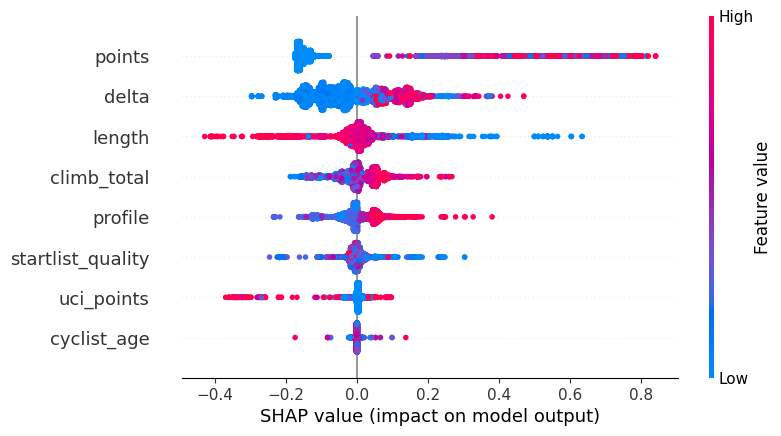

Distributional Explanations Beeswarm Plot:


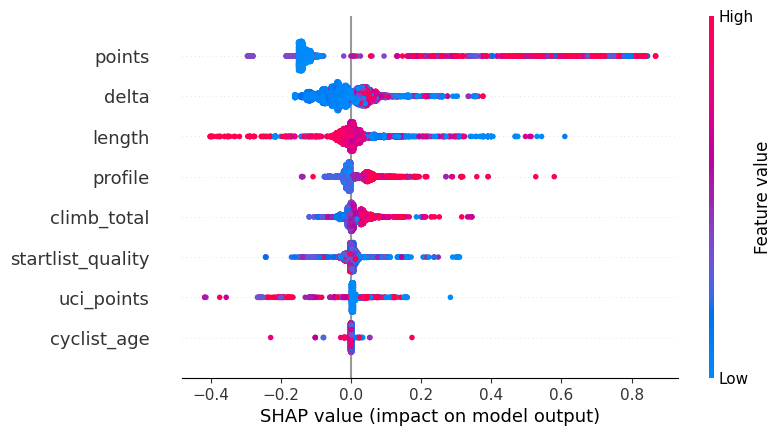

In [13]:
interventional_explanations_dt, distributional_explanations_dt = compute_shap_explanations(
    model=best_model_dt,  # Trained model
    X_train=X_train,      # Training dataset
    X_test=X_test,        # Test dataset
    class_index=1         # Positive class to analyze
)


We immediately notice that the two plots are similar, this suggests that the model could be quite robust and that it does not have a strong interaction between the features and the predictions.
From these graphs we can observe the importance of the features, in particular, 'points' is the feature that impacts the result of the classifier the most, followed by 'delta', while 'cyclist_age' is the least impactful feature. Therefore significant changes in 'points' and 'delta' will have an important effect on the prediction. Furthermore we can see for each feature how the different values ​​influence the prediction of the class. For example: "points" has a low value in the negative points and a high value in the positive points. This means that an increase in the value of "points" is associated with a greater probability of obtaining a positive result for the target class. For the feature 'delta' the opposite is true.

During the initial analysis, we detected a moderate correlation between position and points (-0.31) and a weaker negative correlation with delta (-0.24). The model confirmed these features as the most important for its predictions. Furthermore, the model also identified 'climb_total' and 'length' as ​​relevant, despite the preliminary correlations with 'position' were very low, almost negligible (-0.04 and -0.01 respectively), suggesting the presence of complex non-linear patterns.

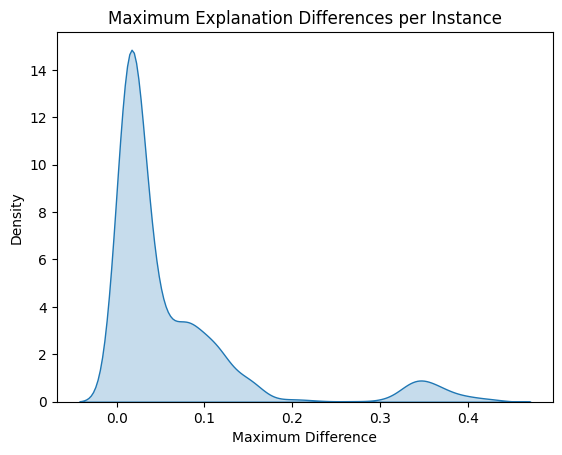

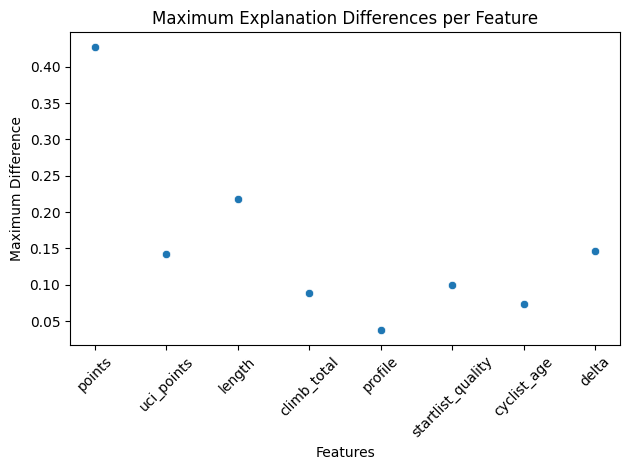

In [14]:
plot_shap_differences(
    interventional_explanations=interventional_explanations_dt,
    distributional_explanations=distributional_explanations_dt,
    X_test=X_test,
    class_index=1
)

The graph shows that most of the maximum differences (or a large number of them) are located around a specific range (near the density peak).

The plot shows that no feature shows very high discrepancies between the two explanation methods.
The higher density in the first plot (height 17.5) suggests that the inter-method comparison at the instance level is quite homogeneous for most observations.
The low height in the second plot (0.35) supports stability between the explanations at the feature level.

### Random Forest

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced', class_weights]
}

'''Contrariamente a GridSearchCV, non vengono provati tutti i valori dei parametri,
ma piuttosto un numero fisso di impostazioni dei parametri viene campionato dalle distribuzioni specificate.
Il numero di impostazioni dei parametri provate è dato da n_iter.'''
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions,
    n_iter=20,
    scoring='f1_weighted',
    cv=5, #Determines the cross-validation splitting strategy
    random_state=42
)
random_search.fit(X_train, y_train)

# Estrai il miglior modello trovato da RandomizedSearchCV
best_model_rf = random_search.best_estimator_

# Addestra il modello sul set di training
best_model_rf.fit(X_train, y_train)

# Effettua le predizioni sul set di test
y_pred_test_rf = best_model_rf.predict(X_test)
y_prob_test_rf = best_model_rf.predict_proba(X_test)[:, 1]  # Probabilità per ROC-AUC

# Stampare i risultati
print("Migliori iperparametri:", random_search.best_params_)
print(f"Accuracy training set: {best_model_rf.score(X_train, y_train):.4f}")
print(f"Accuracy test set: {best_model_rf.score(X_test, y_test):.4f}")

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_test_rf):.4f}")
print(f"ROC-AUC sul test set: {roc_auc_score(y_test, y_prob_test_rf):.4f}")
print("Report di classificazione:\n", classification_report(y_test, y_pred_test_rf))


Migliori iperparametri: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None, 'class_weight': None}
Accuracy training set: 0.9742
Accuracy test set: 0.9537
Accuratezza sul test set: 0.9537
ROC-AUC sul test set: 0.9629
Report di classificazione:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      6139
           1       0.93      0.70      0.80       939

    accuracy                           0.95      7078
   macro avg       0.95      0.85      0.89      7078
weighted avg       0.95      0.95      0.95      7078



In [16]:
importance = best_model_rf.feature_importances_
feature_names = X_train.columns  # Or just the feature names if using numpy
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


             Feature  Importance
0             points    0.752874
2             length    0.075284
7              delta    0.050100
3        climb_total    0.032254
5  startlist_quality    0.031448
1         uci_points    0.020284
4            profile    0.019202
6        cyclist_age    0.018553


100%|===================| 14128/14156 [06:36<00:00]        

Interventional Explanations Beeswarm Plot:


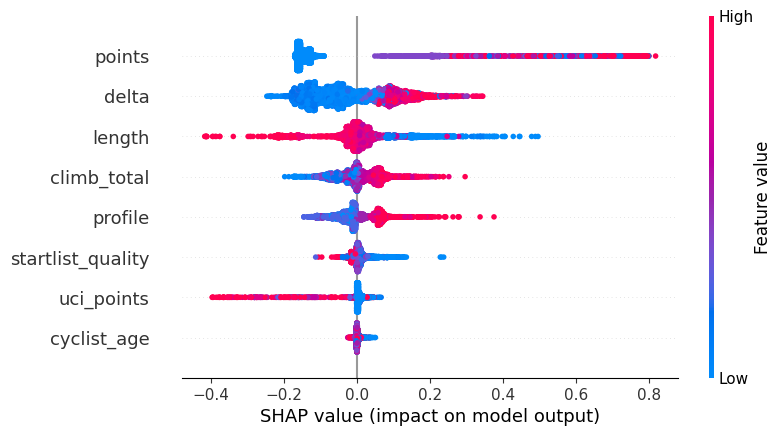

Distributional Explanations Beeswarm Plot:


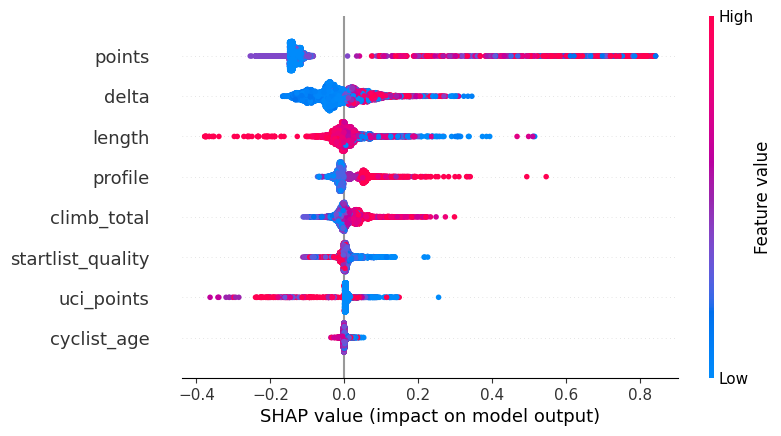

In [17]:
interventional_explanations_rf, distributional_explanations_rf = compute_shap_explanations(
    model=best_model_rf,
    X_train=X_train,
    X_test=X_test,
    class_index=1
)

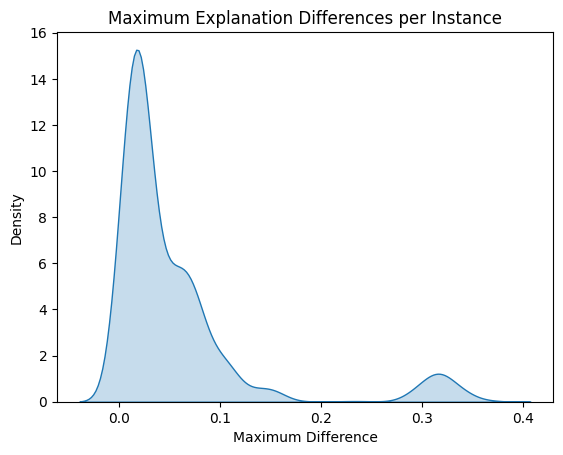

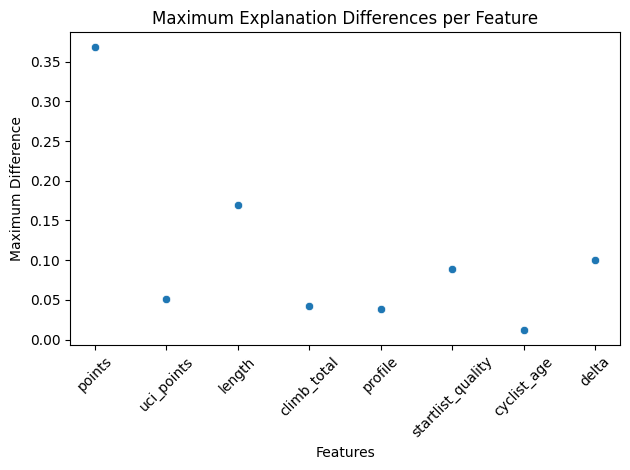

In [18]:
plot_shap_differences(
    interventional_explanations=interventional_explanations_rf,
    distributional_explanations=distributional_explanations_rf,
    X_test=X_test,
    class_index=1
)

### SVM

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import uniform
import numpy as np
from scipy.stats import loguniform

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_weights = 'balanced'

svc = SVC(probability=True, random_state=42)

param_distributions = {
    'C': uniform(0.1, 1),  
    'gamma': ['scale', 'auto'],
    'kernel': ['linear'], 
    'class_weight': [None, 'balanced', class_weights]
}

random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_distributions,
    n_iter=5, 
    cv=2,  
    scoring='f1',  
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting del modello
random_search.fit(X_train_scaled, y_train)
print("Migliori iperparametri SVM:", random_search.best_params_)

best_model_svm = random_search.best_estimator_

y_pred_test_svm = best_model_svm.predict(X_test_scaled)
y_prob_test_svm = best_model_svm.predict_proba(X_test_scaled)[:, 1]

# Stampa dei risultati
print(f"Accuracy training set: {best_model_svm.score(X_train_scaled, y_train):.4f}")
print(f"Accuracy test set: {best_model_svm.score(X_test_scaled, y_test):.4f}")
print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_test_svm):.4f}")
print(f"ROC-AUC sul test set: {roc_auc_score(y_test, y_prob_test_svm):.4f}")
print("Report di classificazione:\n", classification_report(y_test, y_pred_test_svm))


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Migliori iperparametri SVM: {'C': np.float64(0.2428668179219408), 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
Accuracy training set: 0.9231
Accuracy test set: 0.8916
Accuratezza sul test set: 0.8916
ROC-AUC sul test set: 0.8347
Report di classificazione:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      6139
           1       0.61      0.51      0.56       939

    accuracy                           0.89      7078
   macro avg       0.77      0.73      0.75      7078
weighted avg       0.88      0.89      0.89      7078



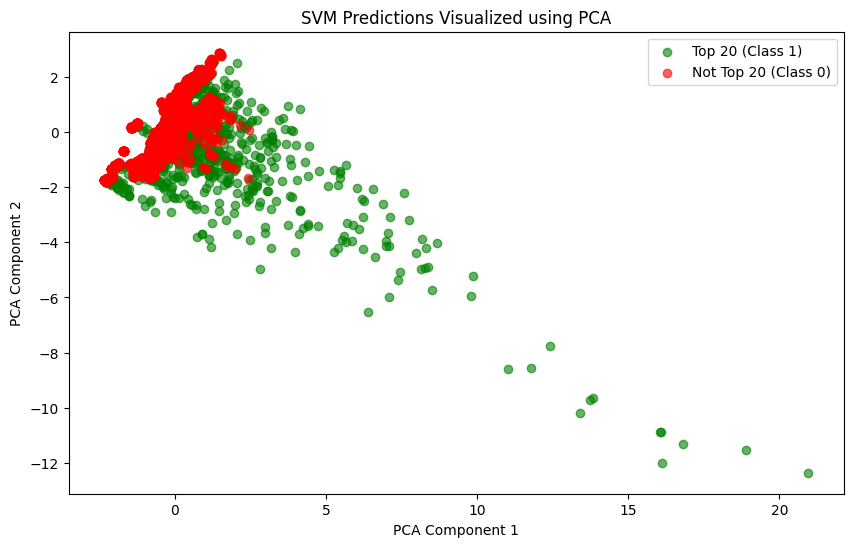

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_pred_pca = best_model_svm.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], color='green', label='Top 20 (Class 1)', alpha=0.6)
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], color='red', label='Not Top 20 (Class 0)', alpha=0.6)
plt.title("SVM Predictions Visualized using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [ ]:
pip install interpret lime


In [29]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.tree import DecisionTreeClassifier, export_text

surrogate_model = DecisionTreeClassifier(max_depth=3)
surrogate_model.fit(X_train_scaled, best_model_svm.predict(X_train_scaled))

print(export_text(surrogate_model, feature_names=X_train.columns))

explainer = LimeTabularExplainer(X_train_scaled,
                                 training_labels=y_train,
                                 mode='classification',
                                 feature_names=X_train.columns,
                                 class_names=['Class 0', 'Class 1'])
lime_exp = explainer.explain_instance(X_test_scaled[0], best_model_svm.predict_proba)

lime_exp.show_in_notebook()


|--- points <= -0.14
|   |--- points <= -0.20
|   |   |--- delta <= 1.44
|   |   |   |--- class: 0
|   |   |--- delta >  1.44
|   |   |   |--- class: 0
|   |--- points >  -0.20
|   |   |--- profile <= -0.09
|   |   |   |--- class: 0
|   |   |--- profile >  -0.09
|   |   |   |--- class: 0
|--- points >  -0.14
|   |--- points <= 0.12
|   |   |--- length <= 0.88
|   |   |   |--- class: 1
|   |   |--- length >  0.88
|   |   |   |--- class: 0
|   |--- points >  0.12
|   |   |--- points <= 0.38
|   |   |   |--- class: 1
|   |   |--- points >  0.38
|   |   |   |--- class: 1



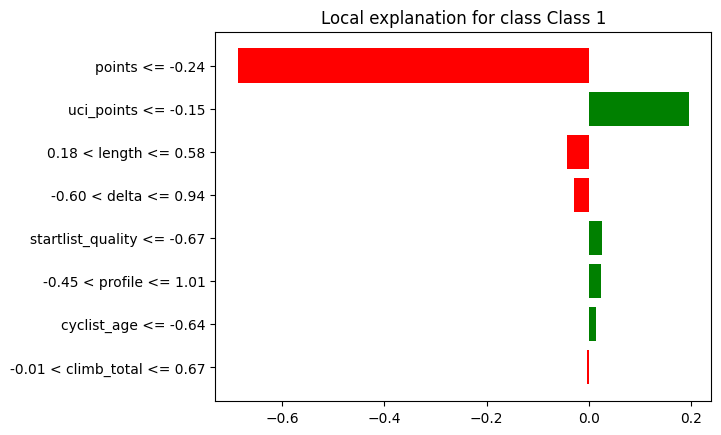

In [30]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

explanation = explainer.explain_instance(X_test_scaled[0],  
                                         best_model_svm.predict_proba)

explanation.as_pyplot_figure()
plt.show()


The predictions show that the rider has a 95% chance of not making the top 20, with "points" and "uci_points" being the main factors in the decision. Both attributes strongly influence the classification towards Class 0 (not in the top 20). Other factors such as "length", "delta", and "profile" have a smaller impact, but still contribute to the prediction. "Climb_total" and "cyclist_age" play minor roles. In general, points and UCI points are the determining factors in classifying the rider as not in the top 20.